In [15]:
import numpy as np
import time

In [16]:
class Pulse:
    def __init__(self, seq_num=0, detected_time=None, travel_time=0, phase=0, mu_poisson=0.1, pulse_type=None):
        self.emitted_time = time.time()
        self.detected_time = detected_time
        self.travel_time = travel_time  # Total travel time of the pulse
        self.phase = phase  # Phase of the pulse
        self.photon_number = np.random.poisson(mu_poisson)
        self.detector = None
        self.seq_num = seq_num 
        self.pulse_type = pulse_type

    def __str__(self):
        return f"Pulse(emitted_time={self.emitted_time}, seq_num={self.seq_num}, detected_time={self.detected_time}, travel_time={self.travel_time}, phase={self.phase}, photon number={self.photon_number}, detector:{self.detector}, pulse type:{self.pulse_type})"

    def beam_splitter(self, x_percentage=50, delay=1):
        # Splitting ratio: x_percentage : y  
        if np.random.rand() <= x_percentage / 100:
            self.travel_time += delay  # Pulse takes the longer path
        # Else, the pulse takes the shorter path (no additional travel time)
        
    def phase_modulator(self, phase_to_add):
        self.phase += phase_to_add
        
    def random_detection(self, x_percentage=50, detector_efficiency=1, dark_counts=0):
        if np.random.rand() <= x_percentage / 100:
            self.detect(0, detector_efficiency, dark_counts)
        else:
            self.detect(1, detector_efficiency, dark_counts)
    
    def detect(self, detector_n, detector_efficiency=1, dark_counts=0):
        assert detector_n in [0, 1]
        
        if self.photon_number > 0:
            detection_probability = np.random.random()
            if detection_probability > detector_efficiency:
                # detector did not detected the photon
                self.detector = None 
            else:
                self.detector = detector_n
                self.detected_time = time.time() + 1.0
            
        elif self.photon_number == 0 and dark_counts > 0:
            # simulate dark counts = prob. that detector can click even if there is no photo
            dark_count_happened = np.random.random()
            if dark_count_happened < dark_counts:
                self.photon_number = 1
                self.detector = self.random_detection(detector_efficiency=detector_efficiency, dark_counts=dark_counts)

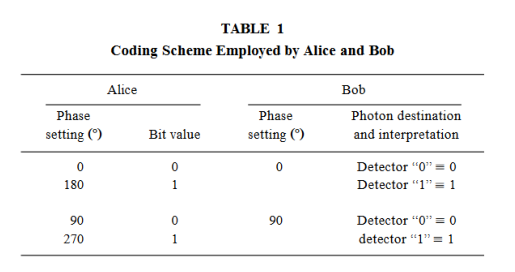

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread(r".\phases_bits.png")

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

In [18]:
def simulate(pulse, phase=0, split_ratio=50):
    pulse.beam_splitter(split_ratio)
    # phase shift applied affects all components of the superposition
    # before we measure the photon, we have to treat it like it went through both arms simultaneously
    pulse.phase_modulator(phase)

def get_bits(phases):
    bits = []
    for phase in phases:
        if phase in [0, np.pi]:
            bits.append(0)
        else:
            bits.append(1)
    return bits

def is_close(value, target, tolerance):
    return abs(value - target) < tolerance

def interference_simulator(pulse, bob_delay, detector_efficiency=1, dark_counts=0):
    tolerance = 0.01  # tolerance for phase comparisons
    if pulse.travel_time == 1:
        # Interference occurs, detectors click deterministically
        if bob_delay == 0:
            if is_close(pulse.phase, 0, tolerance):
                pulse.detect(0, detector_efficiency=detector_efficiency, dark_counts=dark_counts)
            elif is_close(pulse.phase, np.pi, tolerance):
                pulse.detect(1, detector_efficiency=detector_efficiency, dark_counts=dark_counts)
            else:
                # phase was too noisy so there is no interference
                pulse.random_detection(detector_efficiency=detector_efficiency, dark_counts=dark_counts)
        elif is_close(bob_delay, np.pi / 2, tolerance):
            # Add phase to the pulse
            pulse.phase_modulator(np.pi / 2)
            if is_close(pulse.phase, np.pi, tolerance):
                pulse.detect(0, detector_efficiency=detector_efficiency, dark_counts=dark_counts)
            elif is_close(pulse.phase, 2 * np.pi, tolerance):
                pulse.detect(1, detector_efficiency=detector_efficiency, dark_counts=dark_counts)
            else:
                pulse.random_detection(detector_efficiency=detector_efficiency, dark_counts=dark_counts)
    elif pulse.travel_time == 2:
        # Pulse is going second time the long path
        # No interference, detectors click randomly
        pulse.random_detection(detector_efficiency=detector_efficiency, dark_counts=dark_counts)
    else:
        # Pulse is going second time the short path
        # No interference, detectors click randomly
        pulse.phase_modulator(bob_delay)
        pulse.random_detection(detector_efficiency=detector_efficiency, dark_counts=dark_counts)

def is_close_to_any(value, targets, tolerance):
    """Check if value is within tolerance of any target values."""
    return any(abs(value - target) < tolerance for target in targets)

def generate_bits_and_delays_for_Alice(n=100):
    # Generate an array of n random bits
    bits = np.random.randint(2, size=n)
    delays = []
    for bit in bits:
        if bit == 0:
            delay = np.random.choice([0, np.pi/2])
        else:
            delay = np.random.choice([np.pi, 3*np.pi/2])
        delays.append(delay)
    
    #bases = ['X' if delay in [0, np.pi] else 'Y' for delay in delays]
    # Generate bases with tolerance for phase values
    bases = ['X' if is_close_to_any(delay, [0, np.pi], 0.01) else 'Y' for delay in delays]
    return bits, delays, bases

In [19]:
def compare_alphabets(Alice_bases, Bob_delays):
    # compare which detections were valid and note the count of the pulse
    Bob_bases = ['X' if delay == 0 else 'Y' for delay in Bob_delays]
    shared_bases = []
    shared_seq_nums = []
    
    # Compare Alice and Bob's bases
    for i in range(len(Alice_bases)):
        if Alice_bases[i] == Bob_bases[i]:
            # If the bases match, add the base and sequence number to the respective lists
            shared_bases.append(Alice_bases[i])
            shared_seq_nums.append(i)
    
    return shared_bases, shared_seq_nums
            

def key_sifting(pulses, Alice_bases, Bob_delays):
    # First, find out which pulses have a shared basis and their sequence numbers
    shared_bases, shared_seq_nums = compare_alphabets(Alice_bases, Bob_delays)
    
    # Initialize the sifted key list
    sifted_key = []
    confirmed_seq_nums = []
    
    # Iterate over the shared sequence numbers and bases
    for seq_num, base in zip(shared_seq_nums, shared_bases):
        # Find the corresponding pulse based on sequence number
        # Assuming sequence numbers are 1-indexed and match the order of pulses
        pulse = pulses[seq_num]  # Adjust if seq_nums are 0-indexed
        
        # Check if the pulse was detected and has a valid detector outcome
        if pulse.detector is not None and pulse.travel_time == 1:
            # Determine the bit based on the pulse's detector outcome
            # Assuming the same logic for bit determination as previously
            bit = 0 if pulse.detector == 0 else 1
            sifted_key.append(bit)
            confirmed_seq_nums.append(seq_num)
    
    return sifted_key, confirmed_seq_nums


def alice_sift_key(Alice_original_bits, confirmed_seq_nums):
    """
    Sifts Alice's key based on sequence numbers confirmed by Bob.
    """
    sifted_bits = []
    for seq_num in confirmed_seq_nums:
        sifted_bits.append(Alice_original_bits[seq_num])
    
    return sifted_bits


def compare_random_subset(bits1, bits2, percentage):
    if len(bits1) != len(bits2):
        raise ValueError("The arrays must be of the same length.")
    
    # Calculate the number of bits to compare
    num_bits_to_compare = int(len(bits1) * (percentage / 100.0))
    indices_to_compare = np.random.choice(len(bits1), num_bits_to_compare, replace=False)
    matches = sum(bits1[idx] == bits2[idx] for idx in indices_to_compare)
    match_percentage = (matches / num_bits_to_compare) * 100
    
    return match_percentage, list(indices_to_compare)

def compare_random_subset(bits1, bits2, percentage=25, delete_bits=False, epsilon=0.1):
    bits1 = np.array(bits1)
    bits2 = np.array(bits2)
    if len(bits1) != len(bits2):
        raise ValueError("The arrays must be of the same length.")
    try:
        # Calculate the number of bits to compare
        num_bits_to_compare = int(len(bits1) * (percentage / 100.0))
        indices_to_compare = np.random.choice(len(bits1), num_bits_to_compare, replace=False)
        matches = sum(bits1[idx] == bits2[idx] for idx in indices_to_compare)
        match_percentage = (matches / num_bits_to_compare) * 100
        print(f'Match percentage: {match_percentage} %, Estimated QBER: {100-match_percentage:.2f} %')

        hoeff = hoeffding_bound(n=num_bits_to_compare, epsilon=epsilon)
        serfling = serfling_bound(N=len(bits1), n=num_bits_to_compare, epsilon=epsilon)
        print(f"Hoeffding's bound = {hoeff:.3f}, Serfling's bound = {serfling:.3f}")

        # If delete_bits is True, remove the compared bits from the original arrays
        if delete_bits:
            indices_not_compared = np.array([idx for idx in range(len(bits1)) if idx not in indices_to_compare])
            # Create new arrays without the compared bits
            reduced_bits1 = bits1[indices_not_compared]
            reduced_bits2 = bits2[indices_not_compared]

            return reduced_bits1, reduced_bits2, 100-match_percentage
        else:
            return bits1, bits2
    except ZeroDivisionError:
        print("Sifted key is too small to perform error estimation")
        return bits1, bits2

Hoeffding’s and Serfling’s Bounds (the probabilities returned by these bounds) represent the upper limits on the probability that the true QBER deviates from your sample estimate by more than the specified epsilon. It's not the probability of error itself but the confidence you can have in your QBER estimation being within epsilon of the true QBER.

In [20]:
def hoeffding_bound(n, epsilon, a=0, b=1):
    """
    Calculates the upper bound on the probability that the sample mean deviates from
    the expected value by more than epsilon using Hoeffding's Inequality.

    Parameters:
    n (int): Number of independent samples = the number of bits to sample and compare between Alice's and Bob's sifted keys to estimate the QBER.
    epsilon (float): Desired precision level.
    a (float): Lower bound of sample values = 0
    b (float): Upper bound of sample values = 1
        since now we have bits 0,1

    Returns upper bound on the deviation probability.
    """
    return np.exp(-2 * n * epsilon**2 / (b - a)**2)

def serfling_bound(N, n, epsilon):
    """
    Calculates the upper bound on the probability that the sample mean deviates from
    the population mean by more than epsilon using Serfling's Inequality.

    Parameters:
    N (int): Population size = is the total number of bits in the sifted key
    n (int): Sample size (without replacement) = number of bits sampled for estimating the QBER.
    epsilon (float): Desired precision level.

    Returns: upper bound on the deviation probability.
    """
    return np.exp(-2 * n * epsilon**2 / (1 - (n - 1) / N))

In [21]:
import hashlib

def generate_key_hash(key_bits):
    """
    Generates a SHA-3 hash of the given key.
    """
    # Convert the list of bits into a byte string
    bit_string = ''.join(str(bit) for bit in key_bits)
    byte_string = int(bit_string, 2).to_bytes((len(bit_string) + 7) // 8, byteorder='big')
    
    # Generate the SHA-3 hash of the byte string
    hash_obj = hashlib.sha3_256(byte_string)
    hash_hex = hash_obj.hexdigest()
    
    return hash_hex

def compare_hashes(Alice_key, Bob_key):
    if generate_key_hash(Alice_key) == generate_key_hash(Bob_key):
        print(f"Hashes of Alice and Bob's key are the same")
        return True
    else:
        print(f"Hashes of Alice and Bob's key are different")
        return False

def privacy_amplification(bits, final_length_bits=256):
    """
    Applies privacy amplification using the SHA-3 hash function.

    Parameters:
    bits (list of int): The corrected key bits after error correction.
    final_length_bits (int): The desired length of the final key in bits.

    Returns:
    list of int: The final key bits after privacy amplification.
    """
    # Convert the list of bits into a byte string
    bit_string = ''.join(str(bit) for bit in bits)
    byte_string = int(bit_string, 2).to_bytes((len(bit_string) + 7) // 8, byteorder='big')
    
    # Hash the byte string using SHA3-256
    hash_obj = hashlib.sha3_256()
    hash_obj.update(byte_string)
    hashed_bytes = hash_obj.digest()
    
    # Truncate the hashed bytes to the desired final length
    final_byte_length = final_length_bits // 8
    truncated_hashed_bytes = hashed_bytes[:final_byte_length]
    print(f'Final key: {truncated_hashed_bytes}')
    
    # Convert back to bits
    final_key = []
    for byte in truncated_hashed_bytes:
        final_key.extend([int(bit) for bit in bin(byte)[2:].zfill(8)])
    
    return truncated_hashed_bytes # final_key[:final_length_bits]

In [22]:
def simulate_phase_noise(pulse, std_dev=0.05):
    """
    Simulates continuous phase noise by applying a normally distributed random phase shift to each photon's phase.
    The distribution is centered around 0 (mean=0) ==> most likely phase shift is no shift.
    """
    shift = np.random.normal(0, std_dev)
    pulse.phase += shift

def simulate_phase_flip(pulse, phase_flip_probability=0.01):
    """
    Simulates phase-flip errors, where each qubit's phase might be flipped by pi with a given probability.
    """
    flip = np.random.rand() < phase_flip_probability
    if flip:
        if np.random.rand() > 0.5:
            pulse.phase += np.pi
        else:
            pulse.phase -= np.pi

def attenuation(distance_km, attenuation_db_per_km=0.2): 
    # Transmission Loss rate, 0.2 is optimistic value for IR optical fiber
    return 10 ** (-(attenuation_db_per_km * distance_km) / 10)

def simulate_fiber_losses(pulse, distance_km, attenuation_db_per_km=0.2):
    if np.random.rand() >= attenuation(distance_km, attenuation_db_per_km) and pulse.photon_number > 0:
        pulse.photon_number -= 1  # One photon is lost    


In [23]:
def intercept_resend_attack(pulse, Eve_delay_guess, ideal=True):
    """
    #For each pulse, Eve tries to measure it in a randomly chosen basis, potentially altering
    #the pulse's phase (simulating measurement in quantum mechanics), and then resends the
    #pulse to Bob. This function also simulates Eve's attempt to build her version of the key.
    0) Alice sends pulse
    1) Eve runs it in her AMZI
    """
    # Eve guesses the basis randomly to measure the phase
    #eve_basis_guess = np.random.choice([0, np.pi/2])
    # Eve runs it in her AMZI and measure it (what would Bob do)
    pulse.beam_splitter()
    interference_simulator(pulse, bob_delay=Eve_delay_guess)
    # Eve notes done the measurement and generate new pulse
    # - she don't know which phase Alice applied, so she randomly chooses from one of the two options based on her alphabet choice
    # - what about travel time... Eve can't know which path it took, so she basically replicate what Alice did
    measured_bit = pulse.detector

    if Eve_delay_guess == 0:  # Assuming 'X' corresponds to 0 or pi phase
        Alice_phase_guess = np.random.choice([0, np.pi])
    else:  # 'Y' basis, corresponding to pi/2 or 3pi/2 phase
        Alice_phase_guess = np.random.choice([np.pi/2, 3*np.pi/2])
        
    # gen new pulse and keep seq_num (just virtual variable)
    resent_pulse = Pulse(seq_num=pulse.seq_num)
    # in ideal scenario she has on-demand perfect single photon source
    if ideal:
        resent_pulse.photon_number = 1
    # this pulse goes to BS and a phase is applied    
    simulate(resent_pulse, phase=Alice_phase_guess)    

    return resent_pulse, measured_bit

     
def photon_number_splitting(pulse, Eve_delay_guess):
    # Eve can measure number of pulses
    if pulse.photon_number > 1:
        pulse.photon_number -= 1 # measure this photon and get info from it
        extracted_pulse = pulse # do not intercept Alice's pulse
        extracted_pulse.beam_splitter()
        interference_simulator(extracted_pulse, bob_delay=Eve_delay_guess)
        measured_bit = extracted_pulse.detector
        return pulse, measured_bit
    else:
        # perform intercept-resend attack
        return intercept_resend_attack(pulse, Eve_delay_guess)


import scipy.stats as stats

def compare_pulse_ratios(pulses):
    """
    Calculates and compares the ratio of generated signal to decoy pulses 
    against the ratio of these pulses which were actually measured (detected).
    """
    # Initialize counters
    generated_counts = {'signal': 0, 'decoy': 0}
    detected_counts = {'signal': 0, 'decoy': 0}

    # Count generated and detected pulses
    for pulse in pulses:
        if pulse.pulse_type == 'signal':
            generated_counts['signal'] += 1
            if pulse.detector != None:
                detected_counts['signal'] += 1
        elif pulse.pulse_type == 'decoy':
            generated_counts['decoy'] += 1
            if pulse.detector != None:
                detected_counts['decoy'] += 1

    # Calculate ratios
    generated_ratio = generated_counts['signal'] / generated_counts['decoy'] if generated_counts['decoy'] > 0 else float('inf')
    detected_ratio = detected_counts['signal'] / detected_counts['decoy'] if detected_counts['decoy'] > 0 else float('inf')

    # Compare and display ratios
    print(f"Generated signal:decoy ratio = {generated_ratio:.2f}")
    print(f"Detected signal:decoy ratio = {detected_ratio:.2f}")

    # Check for significant discrepancies
    if abs(generated_ratio - detected_ratio) / generated_ratio > 0.2:  # Allowing 20% tolerance
        print("Warning: Significant discrepancy between generated and detected signal:decoy ratios.")
    else:
        print("No significant discrepancy between generated and detected signal:decoy ratios.")

def theoretical_detection_rate(mu, transmission_rate, detector_efficiency):
    """
    Calculates the theoretical detection rate for a given mean photon number (mu),
    transmission rate of the channel, and detector efficiency.
    """
    # For a Poisson-distributed source, the probability of no photons is exp(-mu),
    # so the probability of detection is 1 minus the probability of sending no photons,
    # adjusted by the transmission rate and detector efficiency.
    return (1 - np.exp(-mu * transmission_rate)) * detector_efficiency

def analyze_decoy_states(pulses, transmission_rate, detector_efficiency):
    detected_counts = {'signal': 0, 'decoy': 0, 'decoy_vacuum': 0}
    total_counts = {'signal': 0, 'decoy': 0, 'decoy_vacuum': 0}
    mu_values = {'signal': 0.2, 'decoy': 0.6, 'decoy_vacuum': 0.01}

    for pulse in pulses:
        if pulse.detector != None:
            detected_counts[pulse.pulse_type] += 1
        total_counts[pulse.pulse_type] += 1
    
    print("Detection Rate Analysis:")
    for pulse_type, mu in mu_values.items():
        observed_rate = detected_counts[pulse_type] / total_counts[pulse_type] if total_counts[pulse_type] > 0 else 0
        theoretical_rate = mu_values[pulse_type]
        expected_rate = theoretical_detection_rate(mu, transmission_rate, detector_efficiency)
        
        # Perform a simple statistical test (e.g., chi-squared test for goodness of fit)
        observed = detected_counts[pulse_type]
        expected = total_counts[pulse_type] * expected_rate
        chi2_stat, p_val = stats.chisquare([observed, total_counts[pulse_type] - observed], 
                                           [expected, total_counts[pulse_type] - expected])
        
        print(f"{pulse_type.capitalize()}:\n\t Lossless-noiseless rate: {theoretical_rate}\n\tExpected rate: {expected_rate:.3f}\n\t Observed rate: {observed_rate:.3f}")
        print(f"\tChi-squared statistic: {chi2_stat:.3f}, p-value: {p_val:.3f}")
        
        if p_val < 0.05:
            print("\tAnomaly detected: Possible eavesdropping.")
        else:
            print("\tNo significant anomaly detected.")


def count_pulse_types(pulses, measured=False):
    total_counts = {'signal': 0, 'decoy': 0, 'decoy_vacuum': 0}
    
    if measured:
        for pulse in pulses:
            total_counts[pulse.pulse_type] += 1
            if pulse.detector != None:
                total_counts[pulse.pulse_type] += 1
    else:
        for pulse in pulses:
            total_counts[pulse.pulse_type] += 1
            
    return total_counts

def count_photon_numbers(pulses):
    return    

In [24]:
def generate_pulses(n, decoy_states=False, signal_mu=0.2, decoy_mu=0.6, decoy_vacuum_mu=0.01):
    # parameters set according to: 
    # Y. Liu et al. “Decoy-state quantum key distribution with polarized photons over 200 km”. 
    # In: Opt. Express 18.8 (2010), pp. 8587–8594
    pulses = []
    if decoy_states:
        for i in range(n):
            pulse_type = np.random.choice(['signal', 'decoy', 'decoy_vacuum'], p=[0.25, 0.5, 0.25])
            if pulse_type == 'signal':
                mu = signal_mu
            elif pulse_type == 'decoy':
                mu = decoy_mu
            else:  # vacuum decoy
                mu = decoy_vacuum_mu
            pulse = Pulse(seq_num=i, mu_poisson=mu, pulse_type=pulse_type)
            # note: In reality, only Alice knows which pulses are which, and then she publicly shares this info with Bob
            # so only after that Bob can reveal the "pulse_type"
            pulses.append(pulse)
    else:
        pulses = [Pulse(seq_num=i, mu_poisson=signal_mu) for i in range(n)]
    return pulses

In [25]:
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import padding
import os

def encrypt_message(key, plaintext):
    # Ensure the plaintext is properly padded
    padder = padding.PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(plaintext.encode()) + padder.finalize()
    
    # Generate a random IV
    iv = os.urandom(16)
    
    # Create cipher object and encrypt
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    ciphertext = encryptor.update(padded_data) + encryptor.finalize()
    
    return iv, ciphertext

def decrypt_message(key, iv, ciphertext):
    # Create cipher object and decrypt
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    padded_plaintext = decryptor.update(ciphertext) + decryptor.finalize()
    
    # Remove padding
    unpadder = padding.PKCS7(algorithms.AES.block_size).unpadder()
    plaintext = unpadder.update(padded_plaintext) + unpadder.finalize()
    
    return plaintext.decode()

def send_encrypted_msg(Alice_key, Bob_key):
    # Example usage:
    # Alice sends message to Bob
    raw_message = "Hello, Bob! How are you?"
    print("Alice message:", raw_message)
    # She encodes the message using AES
    iv, encoded_message = encrypt_message(Alice_key, raw_message)
    print("Encoded message (IV + ciphertext):", iv + encoded_message)
    # Bob recieves the message and decodes it
    decoded_message = decrypt_message(Bob_key, iv, encoded_message)
    print("Bob's decoded message:", decoded_message)

In [29]:
import math
""" My Cascade """
def calculate_initial_block_size(qber, length):
    return max(1, int(0.73 * qber * length))

def shuffle_indices(length):
    indices = list(range(length))
    np.random.shuffle(indices)
    return indices

def correct_errors(Alice_key, Bob_key, indices, start, block_size, changes):
    end = min(start + block_size, len(Bob_key))
    block_indices = indices[start:end]
    Bob_parity = sum(Bob_key[idx] for idx in block_indices) % 2
    Alice_parity = sum(Alice_key[idx] for idx in block_indices) % 2
    
    if Bob_parity != Alice_parity:
        while end - start > 1:
            mid = (start + end) // 2
            mid_indices = indices[start:mid]
            Bob_mid_parity = sum(Bob_key[idx] for idx in mid_indices) % 2
            Alice_mid_parity = sum(Alice_key[idx] for idx in mid_indices) % 2
            if Bob_mid_parity != Alice_mid_parity:
                end = mid
            else:
                start = mid
        # Correct the error at the position indices[start]
        corrected_bit = indices[start]
        Bob_key[corrected_bit] = 1 - Bob_key[corrected_bit]
        changes.append(corrected_bit)

def cascade_protocol(Alice_key, Bob_key, qber):
    n = len(Alice_key)
    block_size = calculate_initial_block_size(qber, n)
    no_more_corrections = False

    while not no_more_corrections:
        no_more_corrections = True
        indices = shuffle_indices(n)
        changes = []
        
        for start in range(0, n, block_size):
            correct_errors(Alice_key, Bob_key, indices, start, block_size, changes)

        # Check if corrections affected previous blocks and need re-check
        if changes:
            no_more_corrections = False
            affected_indices = set()
            for change in changes:
                affected_indices.update(range(max(0, change - block_size + 1), min(n, change + block_size)))
            for index in sorted(affected_indices):
                correct_errors(Alice_key, Bob_key, list(range(n)), index, 1, [])
        
        block_size = min(n, 2 * block_size)  # Double block size after each full pass

    return Bob_key

def binary_entropy(p):
    if p == 0 or p == 1:
        return 0
    return -p * math.log2(p) - (1 - p) * math.log2(1 - p)

def cascade_own(Alice_key, Bob_key, qber):
    capacity = 1 - binary_entropy(qber)
    print(f"The channel capacity (theoretical limit for error correction) is: {capacity}")
    corrected_Bob_key = cascade_protocol(Alice_key, Bob_key, qber)
    print("Corrected Bob's Key:", corrected_Bob_key)
    print("Original Alice's Key:", Alice_key)
    iter = 0
    if np.all(corrected_Bob_key==Alice_key):
        print('Correction successful.')
        compare_hashes(Alice_key, corrected_Bob_key)
    else:
        matches = sum(bit_A != bit_B for bit_A, bit_B in zip(Alice_key, corrected_Bob_key))
        print(qber)
        print(f"Qber after first try {qber:=matches / len(Alice_key)}")
        print(qber)
        corrected_Bob_key = cascade_protocol(Alice_key, Bob_key, qber)
    return corrected_Bob_key

""" My Winnow """

def calculate_parity(bits):
    return sum(bits) % 2

def dichotomic_search(alice_block, bob_block):
    left, right = 0, len(alice_block) - 1
    while left < right:
        mid = (left + right) // 2
        alice_parity = calculate_parity(alice_block[left:mid + 1])
        bob_parity = calculate_parity(bob_block[left:mid + 1])
        if alice_parity != bob_parity:
            right = mid
        else:
            left = mid + 1
    alice_block[left] ^= 1
    return left

def winnow_protocol(alice, bob, qber):
    n = len(alice)
    k1 = math.floor(4 * math.log(2) / (3 * qber))
    k2 = math.floor(4 * math.log(2) / qber)
    error_count = 0

    # First two passes using specified block sizes
    for k in [k1, k2]:
        num_blocks = n // k
        for i in range(num_blocks):
            start = i * k
            end = start + k
            alice_parity = calculate_parity(alice[start:end])
            bob_parity = calculate_parity(bob[start:end])
            if alice_parity != bob_parity:
                error_index = dichotomic_search(alice[start:end], bob[start:end])
                error_count += 1

    # BICONF algorithm
    iterations = 0
    while iterations < 10:
        mask = np.random.binomial(1, 0.5, n).astype(bool) # get rand array of bools
        complement_mask = ~mask # get 'opposite' of mask (negate all bools. False->True, True->False)
        
        subsets = [mask, complement_mask]
        new_errors_found = False

        for subset in subsets:
            alice_parity = calculate_parity(alice[subset])
            bob_parity = calculate_parity(bob[subset])
            if alice_parity != bob_parity:
                error_index = dichotomic_search(alice[subset], bob[subset])
                error_count += 1
                new_errors_found = True

        if not new_errors_found:
            break  # Stop if no new errors are found in an iteration

        iterations += 1

    return alice, error_count

"""Cascade example"""
from tno.quantum.communication.qkd_key_rate.base import Message, Permutations, Schedule, ParityStrategy
from tno.quantum.communication.qkd_key_rate.protocols.classical.cascade import (
    CascadeCorrector,
    CascadeReceiver,
    CascadeSender,
)

from tno.quantum.communication.qkd_key_rate.protocols.classical.winnow import (
    WinnowCorrector,
    WinnowReceiver,
    WinnowSender,
)

def cascade_lib(Alice_key, Bob_key, qber, print_s=False):

    message_length = len(Alice_key) # 100000
    qber = qber
    input_message = Message(Alice_key) # Message([int(np.random.rand() > 0.5) for _ in range(message_length)])
    error_message = Message(Bob_key) #Message([x if np.random.rand() > error_rate else 1 - x for x in input_message])
    
    number_of_passes = 8
    sampling_fraction = 0.34
    permutations = Permutations.random_permutation(
        number_of_passes=number_of_passes, message_size=message_length
    )
    parity_strategy = ParityStrategy(
        error_rate=error_rate,
        sampling_fraction=sampling_fraction,
        number_of_passes=number_of_passes,
    )
    
    alice = CascadeSender(message=input_message, permutations=permutations)
    bob = CascadeReceiver(
        message=error_message,
        permutations=permutations,
        parity_strategy=parity_strategy,
    )
    
    corrector = CascadeCorrector(alice=alice, bob=bob)
    summary = corrector.correct_errors()
    
    if summary.output_error > 0.0:
        print(f'There is still error of {summary.output_error} in the key, applying Cascade for second time')
        summary = cascade_lib(Alice_key, Bob_key, qber = summary.output_error, print_s=True)
        return summary

    else:
        print(summary)
        return summary.output_bob.message

def winnow_lib(Alice_key, Bob_key, qber):
    message_length = len(Alice_key) # 100000
    qber = qber
    input_message = Message(Alice_key) # Message([int(np.random.rand() > 0.5) for _ in range(message_length)])
    error_message = Message(Bob_key) #Message([x if np.random.rand() > error_rate else 1 - x for x in input_message])
    
    schedule = Schedule.schedule_from_error_rate(error_rate=qber)
    number_of_passes = np.sum(schedule.schedule)
    permutations = Permutations.random_permutation(
        number_of_passes=number_of_passes, message_size=message_length
    )

    alice = WinnowSender(
        message=input_message, permutations=permutations, schedule=schedule
    )
    bob = WinnowReceiver(
        message=error_message, permutations=permutations, schedule=schedule
    )
    corrector = WinnowCorrector(alice=alice, bob=bob)
    summary = corrector.correct_errors()
    
    print(summary)
    return summary.output_bob

In [27]:
def correct_key(Alice_key, Bob_key, qber, version):
    match version.lower():
        case 'my_cascade':
            # Cascade implemented by me
            corrected_key = cascade_own(Alice_key, Bob_key, qber)
        case 'my_winnow':
            # my Winnow (test) may be incorrect
            corrected_key, total_errors = winnow_protocol(alice_bits, bob_bits, qber)
        case 'winnow':
            # Winnow imported from lib
            corrected_key = winnow_lib(Alice_key, Bob_key, 15)
        case _:
            # Cascade lib
            corrected_key = cascade_lib(Alice_key, Bob_key, qber)
    return corrected_key

In [31]:
def main():
    num_of_bits_sent = 100000
    #signal_mu, decoy_mu, decoy_vacuum_mu = (0.2, 0.6, 0.01)
    #signal_prob, decoy_prob, decoy_vacuum_prob = (0.25, 0.5, 0.25)
    fiber_length = 50 # in kilometers
    att_db_per_km = 0.2
    det_efficiency = 0.5
    phase_noise_std_deviation = 0.01
    phase_flip_probability = 0.01
    dark_count_probability = 0.001
    noise = 1 # 0 = none, 1 = yes, 2 = only transmission losses, 3 = only phase noise
    eavesdropping = 2 # 0 = no eavesdropping; 1 = intercept_resend_attack; 2 = PNS atttack
    error_correction_alg = 'my_cascade' # my_winnow, winnow, cascade
    all_pulses = generate_pulses(num_of_bits_sent, decoy_states=True)
    print(count_pulse_types(all_pulses))
    # prepare
    Alice_bits, Alice_delays, Alice_basis = generate_bits_and_delays_for_Alice(n=num_of_bits_sent)
    Bob_delays = np.random.choice([0, np.pi/2], num_of_bits_sent)
    Eve_delays = np.random.choice([0, np.pi/2], num_of_bits_sent)
    Eve_bits = []
    
    # experiment simulator
    for i, pulse in enumerate(all_pulses):
        # Alice
        simulate(pulse, phase = Alice_delays[i])
        
        if noise == 1:
            simulate_phase_noise(pulse, std_dev=phase_noise_std_deviation)
            simulate_phase_flip(pulse, phase_flip_probability=phase_flip_probability)
            simulate_fiber_losses(pulse, distance_km=fiber_length, attenuation_db_per_km=att_db_per_km)
        elif noise == 2:
            simulate_fiber_losses(pulse, distance_km=fiber_length, attenuation_db_per_km=att_db_per_km)
        elif noise == 3:
            simulate_phase_noise(pulse, std_dev=phase_noise_std_deviation)
            simulate_phase_flip(pulse, phase_flip_probability=phase_flip_probability)
            
        if eavesdropping == 1:
            pulse, eve_bit = intercept_resend_attack(pulse, Eve_delays[i])
        elif eavesdropping == 2:
            pulse, eve_bit = photon_number_splitting(pulse, Eve_delays[i])
            Eve_bits.append(eve_bit)
            
        # Bob
        # 1) long or short
        pulse.beam_splitter()
        # 2) interference
        interference_simulator(pulse, bob_delay = Bob_delays[i], detector_efficiency=det_efficiency, dark_counts=dark_count_probability)
    #Bob_measured_types = count_pulse_types(all_pulses)
    #print(Bob_measured_types)
    
        # if all_pulses[i].detector != None:
            # print(all_pulses[i])
# ---POST PROCESSING---
# get time how long one photon travels... windows has low time precision, so I had to manually add +1 sec to the detection time
    Bob_sifted_key, confirmed_seq_nums = key_sifting(pulses=all_pulses, Alice_bases=Alice_basis, Bob_delays=Bob_delays)
    Alice_sifted_key = alice_sift_key(Alice_bits, confirmed_seq_nums)
    print(Bob_sifted_key)
    print(Alice_sifted_key, len(Alice_sifted_key))
    #compare_pulse_ratios(all_pulses)
    #analyze_decoy_states(all_pulses, transmission_rate=attenuation(fiber_length, attenuation_db_per_km=att_db_per_km), detector_efficiency=det_efficiency)
    Alice_final_key, Bob_final_key, QBER = compare_random_subset(Alice_sifted_key, Bob_sifted_key, percentage=25, delete_bits=True)
    print(f"Remaining keys:\nAlice: {Alice_final_key}\nBob:{Bob_final_key}")
    if Alice_final_key.size > 0:
        compare_hashes(Alice_final_key, Bob_final_key)
        #corrected_bob_key = cascade_protocol(Alice_final_key, Bob_final_key, block_size=int(0.73*QBER)+1)
        corrected_key = correct_key(Alice_final_key, Bob_final_key, QBER/100, version='my_cascade')
        print(np.all(corrected_key==Bob_final_key))
        print("Alice's Corrected Key: ", corrected_key)
        compare_hashes(Alice_final_key, corrected_key)
        Alice_final_shared_key = privacy_amplification(Alice_final_key)
        Bob_final_shared_key = privacy_amplification(corrected_key)
        # Alice sends message to Bob using AES encryption
        send_encrypted_msg(Alice_final_shared_key, Bob_final_shared_key)
        

if __name__ == "__main__":
    main()

{'signal': 25053, 'decoy': 49914, 'decoy_vacuum': 25033}
[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 

First block size is computed as the size of the QBER:
$k_1 ≈ 0.73/Q$

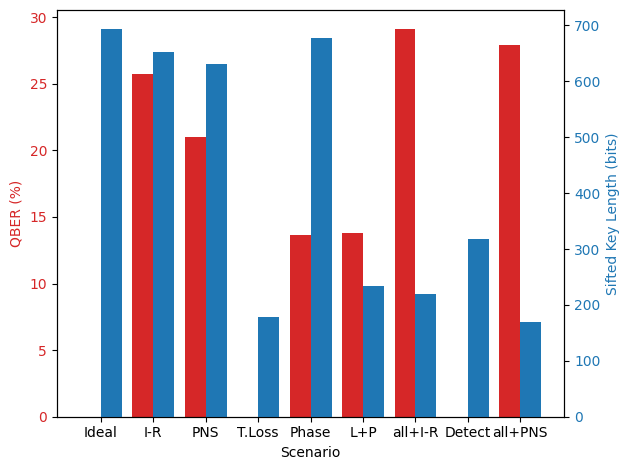

In [16]:
import matplotlib.pyplot as plt
# Example data for QBER (%) and final key length (in bits) for different scenarios
scenarios = ['Ideal', 'I-R', 'PNS', 'T.Loss', 'Phase', 'L+P', 'all+I-R', 'Detect', 'all+PNS']
qber = [0, 25.77, 21.02, 0, 13.61, 13.79, 29.09, 0, 27.91]  # Example QBER values
key_length = [693, 653, 631, 178, 678, 233, 220, 318, 170]  # Example final key lengths

# Setting up the figure and axes for a dual y-axis plot
fig, ax1 = plt.subplots()

# First y-axis for QBER
color = 'tab:red'
ax1.set_xlabel('Scenario')
ax1.set_ylabel('QBER (%)', color=color)
ax1.bar(np.arange(len(scenarios)) - 0.2, qber, 0.4, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for final key length
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sifted Key Length (bits)', color=color)
ax2.bar(np.arange(len(scenarios)) + 0.2, key_length, 0.4, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Setting the scenario names as x-axis labels
plt.xticks(np.arange(len(scenarios)), scenarios)

# Adding a title and adjusting the layout
#plt.title('QBER and Sifted Key Length Across Different Scenarios')
fig.tight_layout()

# Show plot
plt.show()


In [201]:
"""
    TODO:
    - finish Eve key sifting, PNS detection
    - statistics: total pulses vs key size etc.
        - compare PNS vs Intercept-resend
"""

'\n    TODO:\n    - basic eavesdropping\n    - PNS,...\n    - statistics: total pulses vs key size etc.\n        - compare PNS vs Intercept-resend\n'

In [26]:
zeros = ones = twos = threes = fours = fives = 0
higher = []

In [27]:
for i in range(10000000):
    gen_pulse = np.random.poisson(0.1)
    if gen_pulse == 0:
        zeros +=1
    elif gen_pulse == 1:
        ones += 1
    elif gen_pulse == 2:
        twos += 1
    elif gen_pulse == 3:
        threes += 1
    elif gen_pulse == 4:
        fours += 1
    elif gen_pulse == 5:
        fives += 1
    else:
        higher.append(gen_pulse)

In [29]:
print(f'zeros: {zeros}')
print(f'ones: {ones}')
print(f'twos: {twos}')
print(f'threes: {threes}')
print(f'fours: {fours}')
print(f'fives: {fives}')

zeros: 9048187
ones: 904972
twos: 45310
threes: 1495
fours: 34
fives: 2


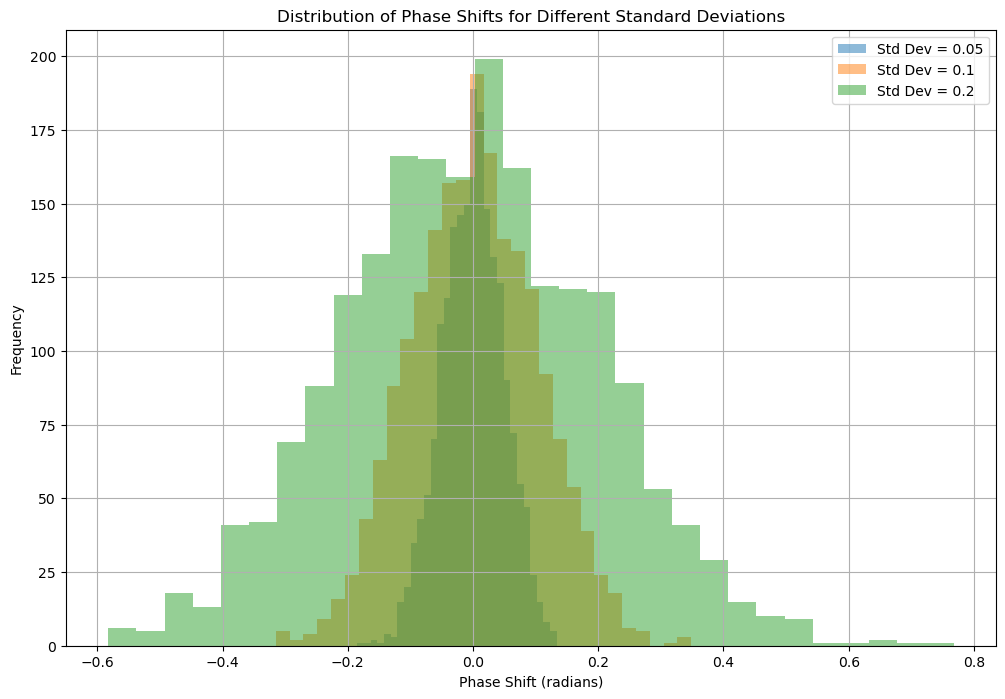

In [14]:
import matplotlib.pyplot as plt

def plot_phase_noise_distribution(std_devs, num_samples=2000):
    plt.figure(figsize=(12, 8))
    for std_dev in std_devs:
        # Generate phase shifts with a mean of 0 and the given standard deviation
        shifts = np.random.normal(0, std_dev, num_samples)
        
        # Plot the histogram of phase shifts
        plt.hist(shifts, bins=30, alpha=0.5, label=f'Std Dev = {std_dev}')

    plt.title('Distribution of Phase Shifts for Different Standard Deviations')
    plt.xlabel('Phase Shift (radians)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_phase_noise_distribution([0.05, 0.1, 0.2])


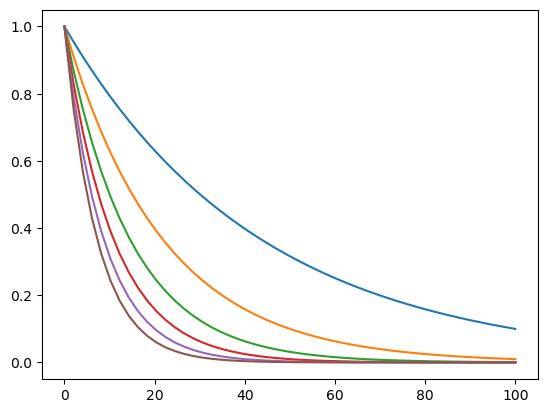

In [41]:
# Losses in optical fibers
T = lambda att, length: 10 ** (-(att * length) / 10)
lengths = np.linspace(0,100)

for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    plt.plot(lengths, T(i,lengths))

In [47]:
total_photons = 100
lost_photons = 0
for i in range(total_photons):
    if np.random.rand() >= T(0.3, 50):
        lost_photons += 1  # One photon is lost  
print(f"from {total_photons} total photons, {lost_photons} was lost")

from 100 total photons, 98 was lost


In [ ]:
def detect_pns_attack(alice_pulses, bob_detected_pulses, expected_transmission_rate):
    """
    Detects potential PNS attacks by comparing expected and observed detection rates
    for signal and decoy states.

    Parameters:
    alice_pulses (list of Pulse): The pulses sent by Alice, with type attributes ('signal', 'decoy_weak', 'decoy_vacuum').
    bob_detected_pulses (list of bool): Whether each pulse was detected by Bob.
    expected_transmission_rate (float): The expected transmission rate of the optical fiber.

    Returns:
    bool: True if a PNS attack is detected, False otherwise.
    """
    # Count the number of each type of pulse and how many were detected
    types = ['signal', 'decoy_weak', 'decoy_vacuum']
    counts = {t: 0 for t in types}
    detected_counts = {t: 0 for t in types}

    for pulse, detected in zip(alice_pulses, bob_detected_pulses):
        if pulse.photon_number > 0:  # Count only if the pulse was intended to be non-empty
            counts[pulse.type] += 1
            if detected:
                detected_counts[pulse.type] += 1

    # Calculate the observed detection rates
    observed_rates = {t: detected_counts[t] / counts[t] if counts[t] > 0 else 0 for t in types}

    # Compare observed rates to expected rates based on transmission and mean photon numbers
    # For simplicity, let's just print the rates for now
    print("Expected vs. Observed Detection Rates:")
    for t in types:
        print(f"{t}: Expected ~{expected_transmission_rate:.2f}, Observed {observed_rates[t]:.2f}")

    # Simple anomaly detection: if observed rate for decoy_vacuum or decoy_weak is significantly
    # lower than expected, it may indicate a PNS attack
    for t in ['decoy_weak', 'decoy_vacuum']:
        if observed_rates[t] < expected_transmission_rate * 0.8:  # 20% threshold for simplicity
            return True  # Anomaly detected

    return False  # No anomaly detected